# Custom Particle Distribution and Cloud Pressure Height

Following the custom haze layer tutorial, this tutorial you will learn: 

1. How to generate your own Mie coefficients for a given radius grid
2. How to compute the optics of an aerosol for your custom radius grid with an arbitrary fsed, and pressure height
3. How to inject this aerosol as a custom layer into an atmospheric model for PICASO

You need to have downloaded PICASO, Virga. This is particularly useful for retrievals with PICASO.

First, let's import all the necessary packages:

In [1]:
#standards
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
#main programs

#radiative transfer and atmosphere code
from picaso import justdoit as pdi

#cloud code
from virga import justdoit as vdi


#plotting tools
from picaso import justplotit as ppi
from virga import justplotit as vpi
ppi.output_notebook()

import matplotlib.pyplot as plt 

Loading BokehJS ...

Okay, now let's grab those Mieff coefficients we just calculated.

In [2]:
mieff_dir = '/Users/nbatalh1/Documents/data/virga_0,3_15_R300/'
qext, qscat, cos_qscat, nwave, radius, wave_in = vdi.get_mie('SiO2',directory=mieff_dir)

## Pick the Cloud Distribution Function

### Gaussian particle distribution 

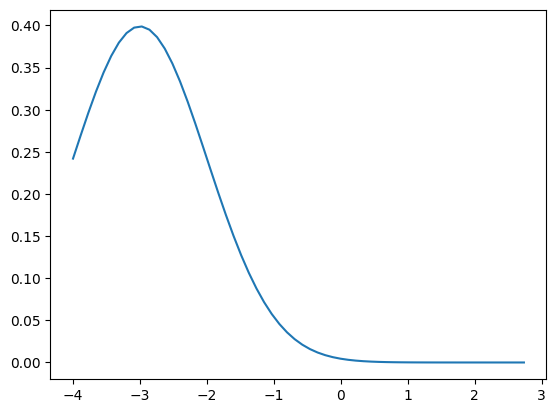

In [3]:
sigma = 1 #width of the distribution
mu = -7 # mean particle size 
logradius = np.log10(radius)
dist = (1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (logradius - mu)**2 / (2 * sigma**2)))
plt.plot(logradius+4, dist)      


Pick an approximate particle density (if using a fitting code this will be a free parameter) 

In [33]:
ndz = 5e6 #that's particles/cm^2 but over the entire region of atmosphere where we're sticking aerosol

opd,w0,g0,wavenumber_grid=vdi.calc_optics_user_r_dist(wave_in, ndz ,radius, pdi.u.cm,dist,
                                                      qext, qscat, cos_qscat)

##  Pick $f_{sed}$ and cloud base pressure

(0.01, 10)

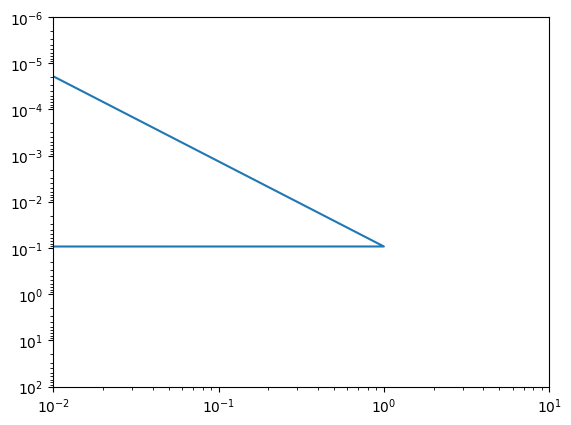

In [34]:
nlayer = 30
pressure =  np.logspace(-6,2,nlayer)
z = np.linspace(100,0,nlayer)#just toy model here
scale_h = 10 #toy model (could grab from picaso calc)

base_pressure = 1e-1 # let's start by setting the haze layer base at 0.1 bars
fsed=1 #this is more just an exponential scaling to control the cloud drop off, and is not connected to particle size

opd_h = pressure*0+10
opd_h[base_pressure<pressure]=0
opd_h[base_pressure>=pressure]=opd_h[base_pressure>=pressure]*np.exp(
                              -fsed*z[base_pressure>=pressure]/scale_h)
opd_h = opd_h/np.max(opd_h)
plt.loglog(opd_h, pressure)
plt.ylim(1e2,1e-6)
plt.xlim(1e-2,10)

In [35]:
#here's where we shove all the variables into a dataframe PICASO can read
df_cld = vdi.picaso_format_slab(base_pressure,opd, w0, g0, wavenumber_grid, pressure, 
                                          p_decay=opd_h)

Let's checkout our optical parameters

In [36]:
nwno = len(wavenumber_grid) 
ppi.show(ppi.plot_cld_input(nwno, nlayer,df=df_cld,pressure=pressure, wavelength=1e4/wavenumber_grid))

## Now run `PICASO`

In [37]:
opa = pdi.opannection(wave_range=[0.3,14])
case1 = pdi.inputs()

case1.phase_angle(0)


#here we are going to have to specify gravity through R and M since we need it in the Flux calc
case1.gravity(mass=1, mass_unit=pdi.u.Unit('M_jup'),
              radius=1.2, radius_unit=pdi.u.Unit('R_jup'))

#here we are going to have to specify R as well
case1.star(opa, 4000,0.0122,4.437,radius=0.7, radius_unit = pdi.u.Unit('R_sun') )

#atmo -- make sure your pressure grid matches the one you computed your haze on!
case1.atmosphere( df = pdi.pd.DataFrame({'pressure':np.logspace(-6,2,31),
                                                 'temperature':np.logspace(-9,3,31)*0+600, #just an isothermal one for simplicity
                                                 "H2":np.logspace(-9,3,31)*0+0.837,
                                                 "He":np.logspace(-9,3,31)*0+0.163,
                                                 "H2O":np.logspace(-9,3,31)*0+1e-4}))

And compute and plot our clear transmission spectrum, without our haze:

In [38]:

df= case1.spectrum(opa, full_output=True,calculation='transmission')

wno, rprs2  = df['wavenumber'] , df['transit_depth']
wno, rprs2 = pdi.mean_regrid(wno, rprs2, R=300)
full_output = df['full_output']

ppi.show(ppi.spectrum(wno,rprs2*1e6,plot_width=500))


Now, let's add in that hazy information. We need to make sure the pressure grids match (by reducing the layers by one because of PICASO's idiosyncrasies).

In [39]:
case1.clouds(df=df_cld.astype(float))
hazy= case1.spectrum(opa, full_output=True,calculation='transmission')
hazyx,hazyy =hazy['wavenumber'] , hazy['transit_depth']
hazyx,hazyy = pdi.mean_regrid(hazyx,hazyy, R=300)

Let's compare our hazy spectrum to our clear spectrum!

In [40]:
ppi.show(ppi.spectrum([wno,hazyx],[(rprs2*1e6),(hazyy*1e6)],
                  legend=['clear','hazy'],plot_width=900,plot_height=300))

Very cloud! Verification we can see the SiO2 feature at 9um

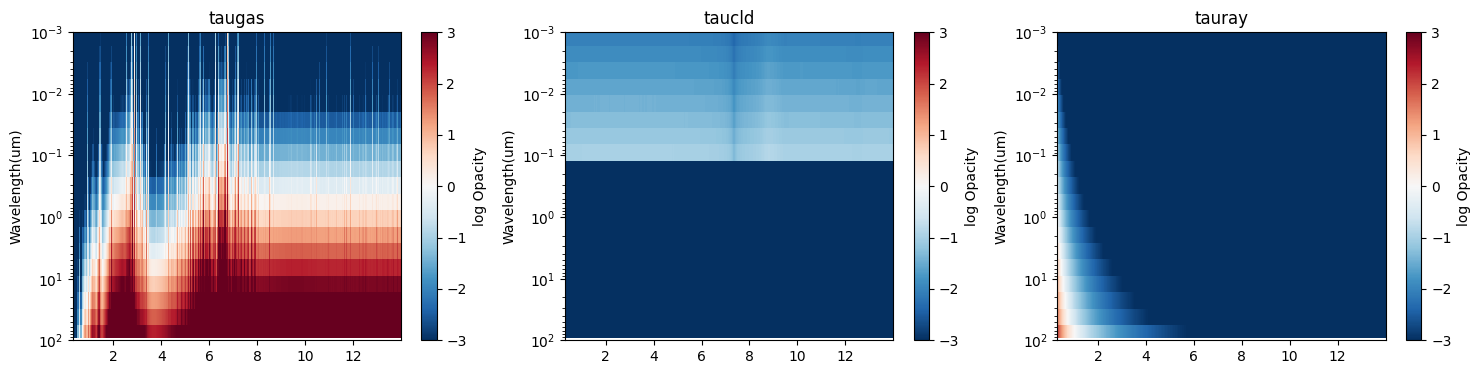

In [41]:
ppi.heatmap_taus(hazy)